In [ ]:
# 필요한 라이브러리 로드
import tensorflow as tf
import keras
from tensorflow.keras import *
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.utils import *
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Activation
import tensorflow.keras.backend as K

import glob, os, cv2
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

from google.colab import drive
from google.colab.patches import cv2_imshow

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 이미지 파일이 존재하는지 확인
def is_image(file_path):
    try:
        img = Image.open(file_path)
        img.verify()
        return True
    except (IOError, SyntaxError) as e:
        return False

# 이미지 파일이 존재하는 경로 확인
def find_img_path(start_path):
    for root, dirs, files in os.walk(start_path):
        for file in files:
            file_path = os.path.join(root, file)
            if is_image(file_path):
                return root
    return None

In [ ]:
# 이미지가 저장된 zip 파일의 경로와 이미지를 압축 해제할 경로 설정
ZIP_PATH = '/content/drive/MyDrive/backup/track_dataset.zip'
PATH = '/content/tmp'

if os.path.exists(PATH):
  !rm -r /content/tmp

os.makedirs(PATH, exist_ok=True)
!unzip $ZIP_PATH -d /content/tmp/ > /dev/null

img_path = find_img_path(PATH)
file_list = glob.glob(f'{img_path}/*.jpg') # edit the directory to your own path

In [ ]:
# 이미지와 각 이미지의 목표값 저장
label=[]
img=[]

for file in tqdm(file_list):
  X = cv2.imread(file)

  try:
    label.append([float(file.split('/')[-1].split('_')[0]), float(file.split('/')[-1].split('_')[1])])
    img.append(X[130:280, :])
  except:
    pass

input = label
label=np.array(input)
img=np.array(img)

label=(label-150)/150 # 목표값이므로 -1부터 1범위로 저장. 활성화 함수도 목표값이 드러날 수 있어야 함
label.shape, img.shape # 저장된 데이터셋 확인 / (이미지 갯수, 2) (이미지 갯수, 150, 300, 3)의 형태이여야 함

100%|██████████| 226/226 [00:00<00:00, 532.37it/s]


((226, 2), (226, 150, 300, 3))

In [ ]:
# 커스텀 활성화 함수 정의
def mish(x):
  return x * K.tanh(K.softplus(x))

# 트레이닝에 학습률 설정
def scheduler(epoch, learningrate):
  if epoch < 100:
    return learningrate
  else:
    return learningrate * tf.math.exp(-0.1)

# 데이터 아그먼트 설정
def augment(image, label):
  # examples
  # image = tf.image.random_flip_left_right(image)
  # image = tf.image.random_flip_up_down(image)
  # image = tf.image.random_brightness(image, max_delta=0.1)
  return image, label

dataset = tf.data.Dataset.from_tensor_slices((img, label))
augmented_dataset = dataset.map(augment)
get_custom_objects().update({'mish': Activation(mish)})

In [ ]:
# 훈련/검증 데이터셋 비율 정의 및 batch 사이즈 정의
ratio = 0.9
train_size = int(ratio * len(img))
val_size = len(img) - train_size

train_dataset = augmented_dataset.take(train_size)
validation_dataset = augmented_dataset.skip(train_size)

batch_size = 32

train_ds = train_dataset.shuffle(buffer_size=train_size).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds = validation_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# 훈련 시킬 모델의 아키텍쳐 정의
input1 = Input(shape=(150, 300, 3,))
conv1 = Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), padding="same")(input1)
norm1 = BatchNormalization()(conv1)
act1 = Activation(mish)(norm1)
pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(act1)
conv2 = Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), padding="same")(pool1)
norm2 = BatchNormalization()(conv2)
act2 = Activation(mish)(norm2)
conv3 = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="same")(act2)
norm3 = BatchNormalization()(conv3)
act3 = Activation(mish)(norm3)
add1 = Add()([act2, act3])
conv4 = Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), padding="same")(add1)
norm4 = BatchNormalization()(conv4)
act4 = Activation(mish)(norm4)
conv5 = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(act4)
norm5 = BatchNormalization()(conv5)
act5 = Activation(mish)(norm5)
add2 = Add()([act4, act5])
conv6 = Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2), padding="same")(add2)
norm6 = BatchNormalization()(conv6)
act6 = Activation(mish)(norm6)
conv7 = Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding="same")(act6)
norm7 = BatchNormalization()(conv7)
act7 = Activation(mish)(norm7)
add3 = Add()([act6, act7])
conv8 = Conv2D(filters=256, kernel_size=(3, 3), strides=(2, 2), padding="same")(add3)
norm8 = BatchNormalization()(conv8)
act8 = Activation(mish)(norm8)
conv9 = Conv2D(filters=512, kernel_size=(3, 3), strides=(2, 2), padding="same")(act8)
norm9 = BatchNormalization()(conv9)
act9 = Activation(mish)(norm9)
flat1 = Flatten()(act9)
dense1 = Dense(128)(flat1)
norm10 = BatchNormalization()(dense1)
act10 = Activation(mish)(norm10)
dense2 = Dense(64)(act10)
norm11 = BatchNormalization()(dense2)
act11 = Activation(mish)(norm11)
dense3 = Dense(64)(act11)
norm12 = BatchNormalization()(dense3)
act12 = Activation(mish)(norm12)
dense4 = Dense(2, activation="tanh")(act12)

model = Model(inputs=input1, outputs=dense4)

In [ ]:
# 모델을 훈련할 때 필요한 설정 정의 (조기 중단, 체크 포인트, 훈련률)
es = EarlyStopping(monitor='val_loss', mode='min', patience=15, min_delta=1e-4)
mc = ModelCheckpoint(filepath='/content/drive/MyDrive/Track_M10.h5', monitor='val_loss', mode='min', save_best_only=True)
lr = LearningRateScheduler(scheduler)

opt = Adam()
model.compile(optimizer=opt, loss='MAE', metrics=['accuracy'])
model.optimizer.lr.numpy()

0.001

In [ ]:
# 훈련 시작
history = model.fit(train_ds, epochs=1000, validation_data=validation_ds, callbacks=[mc, es, lr])

Epoch 1/1000
7/7 [==============================] - ETA: 0s - loss: 0.5289 - accuracy: 0.4286

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 19s 655ms/step - loss: 0.5289 - accuracy: 0.4286 - val_loss: 0.9984 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/1000
7/7 [==============================] - 0s 71ms/step - loss: 0.3933 - accuracy: 0.4187 - val_loss: 0.9799 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/1000
7/7 [==============================] - 0s 70ms/step - loss: 0.2679 - accuracy: 0.3990 - val_loss: 0.6698 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/1000
7/7 [==============================] - 0s 71ms/step - loss: 0.1910 - accuracy: 0.3202 - val_loss: 0.5468 - val_accuracy: 0.1739 - lr: 0.0010
Epoch 5/1000
7/7 [==============================] - 0s 26ms/step - loss: 0.1874 - accuracy: 0.3596 - val_loss: 0.6937 - val_accuracy: 0.0870 - lr: 0.0010
Epoch 6/1000
7/7 [==============================] - 0s 28ms/step - loss: 0.1468 - accuracy: 0.3005 - val_loss: 0.6793 - val_accuracy: 0.0870 - lr: 0.0010
Epoch 7/1000
7/7 [==============================] - 0s 26ms/step - loss: 0.

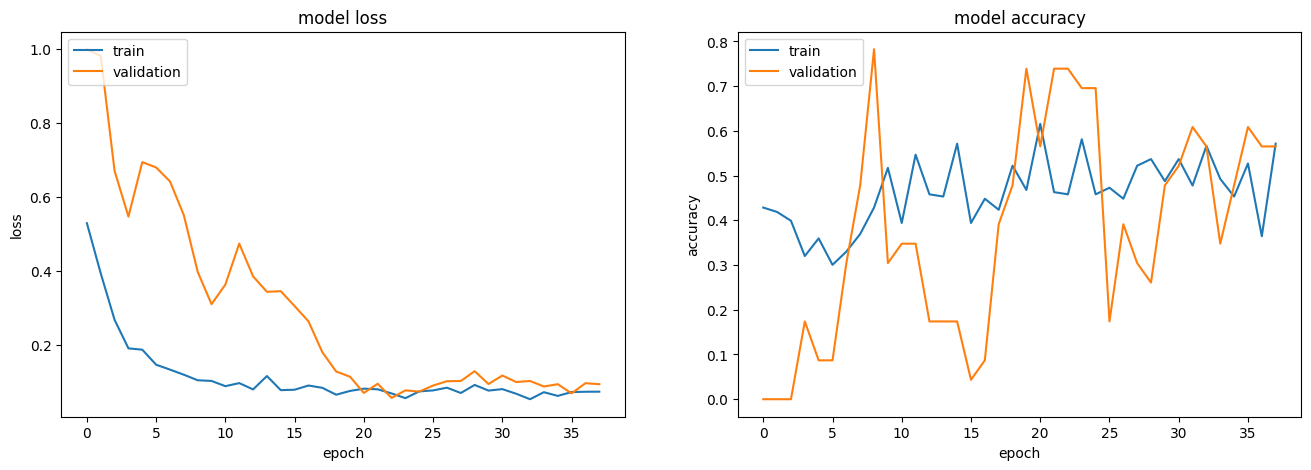

In [ ]:
plt.figure(figsize=(16,5))

# 만들어진 모델에 대해 train dataset과 validation dataset의 loss를 그래프로 표현
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# 만들어진 모델에 대해 train dataset과 validation dataset의 accuracy를 그래프로 표현
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f'model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [ ]:
# 데이터셋에서 임의의 사진 추출
def pick_random_img(directory):
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    if not files:
        raise ValueError(f"No files found in directory: {directory}")

    random_file = random.choice(files)
    return os.path.join(directory, random_file)

In [ ]:
# 10개의 사진을 추출하여 결과 비교 raw와 result가 얼마나 비슷한지 확인
for i in range(10):
    data_path = pick_random_img(img_path)
    raw_data = [(float(data_path.split('/')[-1].split('_')[0]) - 150) / 150, (float(data_path.split('/')[-1].split('_')[1]) - 150) / 150]

    # Test the result of your model
    X = cv2.imread(data_path)
    crop_img = X[130:280, :]
    result = model(np.array([crop_img]).astype(np.float32)).numpy()[0]

    print(f"raw: [{raw_data[0]:.4f}, {raw_data[1]:.4f}], \t result: [{result[0]:.4f}, {result[1]:.4f}]")

raw: [-0.3067, -0.3067], 	 result: [-0.3083, -0.3684]
raw: [-0.4133, -0.4133], 	 result: [-0.4537, -0.3761]
raw: [-0.4933, -0.4933], 	 result: [-0.4985, -0.4165]
raw: [0.1200, 0.1200], 	 result: [0.0746, 0.0473]
raw: [-0.6800, -0.6800], 	 result: [-0.9078, -0.8229]
raw: [-0.2400, -0.2400], 	 result: [-0.2523, -0.2779]
raw: [0.8267, 0.8267], 	 result: [0.8740, 0.8467]
raw: [0.1600, 0.1600], 	 result: [0.0153, -0.0983]
raw: [-0.5733, -0.5733], 	 result: [-0.6038, -0.5750]
raw: [0.2000, 0.2000], 	 result: [0.0010, -0.1484]


In [ ]:
# 그래프가 유효하고 직접 데이터를 비교해도 유효하다고 판단되면 생성된 모델 저장
model.save('Track_Follow_Model.h5')